In [10]:
import geopandas as gpd
import pandas as pd
import osmnx as ox

In [6]:
file_path = '../Data/'
output_file_path = file_path + 'Output/'

# Street network in LA county

In [4]:
G = ox.graph_from_place('Los Angeles County, CA, USA', network_type='drive')

# Street network in LA urban settlement area, dataverse

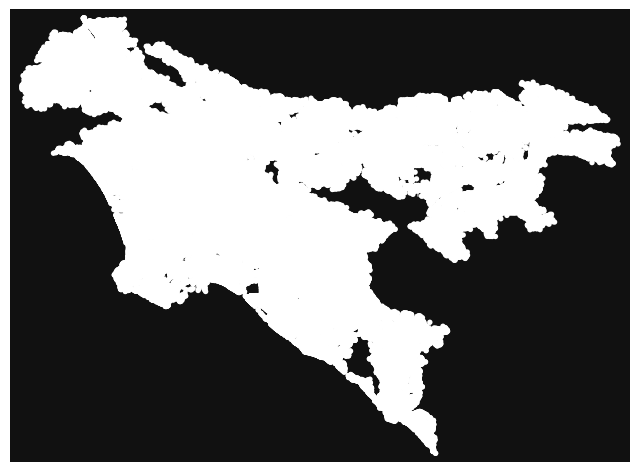

In [8]:
# street network for LA urban settlement area
G_graphml = ox.io.load_graphml(file_path + 'los_angeles-14.graphml')
fig, ax = ox.plot_graph(G_graphml)

In [11]:
# California census tract downloaded from census bureau
CA_22tract = gpd.read_file(file_path + "tl_2022_06_tract/tl_2022_06_tract.shp")

In [13]:
# Los Angeles census tract used by uber movements
uber_tract = gpd.read_file(file_path + "los_angeles_censustracts.json")

In [14]:
CA_22tract.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [15]:
CA_22tract_crs = CA_22tract.to_crs(4326)
CA_22tract_crs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
uber_tract.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf = gdf_nodes.reset_index(drop=False)

In [18]:
gdf_proj = ox.project_gdf(gdf, to_latlong=True)
gdf_proj['x'] = gdf_proj['geometry'].x
gdf_proj['y'] = gdf_proj['geometry'].y

In [19]:
gdf_proj.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# attach (spatial join) census tract GEOID and Uber Movement Tract Movement ID to all the nodes in LA county

In [33]:
selected_cols = ["osmid", "y", "x", "highway", "street_count", "ref",
                 "geometry", "GEOID"]

gdf_proj_tract = gpd.sjoin(gdf_proj, CA_22tract_crs, how='left', predicate='within')[selected_cols]
gdf_proj_tract_uber = gpd.sjoin(gdf_proj_tract, uber_tract, how='left', predicate='within')[selected_cols + ["MOVEMENT_ID", "TRACT"]]
gdf_proj_tract_uber

,osmid,y,x,highway,street_count,ref,geometry,GEOID,MOVEMENT_ID,TRACT
0,653656,33.959897,-118.377054,traffic_signals,4,NaN,POINT (-118.37705 33.95990),06037601401,497,601401
1,653681,33.989402,-118.400313,NaN,3,NaN,POINT (-118.40031 33.98940),06037702600,248,702600
2,668182,33.927475,-118.103512,motorway_junction,3,10,POINT (-118.10351 33.92748),06037550301,1776,550300
3,668183,33.923716,-118.104409,motorway_junction,3,NaN,POINT (-118.10441 33.92372),06037550301,1776,550300
4,668233,33.925082,-118.334369,NaN,3,NaN,POINT (-118.33437 33.92508),06037602513,404,600502
...,...,...,...,...,...,...,...,...,...,...
174852,10282727210,34.460711,-118.631237,NaN,1,NaN,POINT (-118.63124 34.46071),06037920119,NaN,NaN
174853,10921172356,34.482443,-118.548312,NaN,1,NaN,POINT (-118.54831 34.48244),06037920120,NaN,NaN
174854,10994920986,34.474011,-118.638379,turning_circle,1,NaN,POINT (-118.63838 34.47401),06037920116,NaN,NaN
174855,11174591011,34.430070,-118.559845,NaN,4,NaN,POINT (-118.55984 34.43007),06037920114,NaN,NaN


# Sample 100,000 nodes as origin and destination (100,000 OD pairs) in Los Angeles County

In [22]:
origin = gdf_proj_tract_uber.sample(100000, random_state=12345,
                                    replace=True).copy()
origin = origin[["osmid", "y", "x", "GEOID", "MOVEMENT_ID"]]
origin.columns = ['oid', 'oy', 'ox', 'oGEOID', 'oMOVEMENT_ID']
destin = gdf_proj_tract_uber.sample(100000, random_state=12345,
                                    replace=True).copy()
destin = destin[["osmid", "y", "x", "GEOID", "MOVEMENT_ID"]]
destin.columns = ['did', 'dy', 'dx', 'dGEOID', 'dMOVEMENT_ID']

In [23]:
origin = origin.reset_index(drop=True)
destin = destin.reset_index(drop=True)

In [24]:
temp_OD = pd.concat([origin, destin], sort=False, axis=1)
temp_OD = temp_OD.drop(temp_OD[temp_OD['oid'] == temp_OD['did']].index)

# attach (spatial join) census tract GEOID and Uber Movement Tract Movement ID to all the nodes in LA urban area

In [25]:
gdfml_nodes, gdfml_edges = ox.graph_to_gdfs(G_graphml)
gdfml = gdfml_nodes.reset_index(drop=False)

In [26]:
gdfml_proj = ox.project_gdf(gdfml, to_latlong=True)
gdfml_proj['x'] = gdfml_proj['geometry'].x
gdfml_proj['y'] = gdfml_proj['geometry'].y

In [31]:
gdfml_proj_tract = gpd.sjoin(gdfml_proj, CA_22tract_crs, how='left',
                             predicate='within')
gdfml_proj_tract_clean = gdfml_proj_tract[
    ["osmid", "y", "x", "highway", "street_count", "ref", "geometry", "GEOID"]]
gdfml_proj_tract_uber = gpd.sjoin(gdfml_proj_tract_clean, uber_tract,
                                  how='left', predicate='within')
gdfml_proj_tract_uber_clean = gdfml_proj_tract_uber[
    ["osmid", "y", "x", "highway", "street_count", "ref", "geometry", "GEOID",
     "MOVEMENT_ID", "TRACT"]]
gdfml_proj_tract_uber_clean

,osmid,y,x,highway,street_count,ref,geometry,GEOID,MOVEMENT_ID,TRACT
0,19344785,33.436225,-117.618646,NaN,3,NaN,POINT (-117.61865 33.43622),06059042107,NaN,NaN
1,19344864,33.415039,-117.603252,NaN,3,NaN,POINT (-117.60325 33.41504),06059042116,NaN,NaN
2,19345060,33.441800,-117.627369,motorway_junction,3,76,POINT (-117.62737 33.44180),06059042106,NaN,NaN
3,49119283,33.392696,-117.593507,NaN,3,NaN,POINT (-117.59351 33.39270),06073018700,NaN,NaN
4,49164015,33.391360,-117.593414,NaN,3,NaN,POINT (-117.59341 33.39136),06073018700,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
279328,8266155336,34.274912,-118.563144,NaN,3,NaN,POINT (-118.56314 34.27491),06037108204,761,108201
279329,8266176308,34.292560,-118.572939,NaN,3,NaN,POINT (-118.57294 34.29256),06037108202,762,108202
279330,8266890411,34.090761,-118.364885,NaN,3,NaN,POINT (-118.36489 34.09076),06037700200,2108,700200
279331,8280001717,34.030724,-118.416856,NaN,3,NaN,POINT (-118.41686 34.03072),06037271704,1581,271701


# Sample 100,000 nodes as origin and destination (100,000 OD pairs) in Los Angeles County

In [38]:
originml = gdfml_proj_tract_uber_clean.sample(100000, replace=True).copy()
originml = originml[["osmid", "y", "x", "GEOID", "MOVEMENT_ID"]]
originml.columns = ['oid', 'oy', 'ox', 'oGEOID', 'oMOVEMENT_ID']
destinml = gdfml_proj_tract_uber_clean.sample(100000, replace=True).copy()
destinml = destinml[["osmid", "y", "x", "GEOID", "MOVEMENT_ID"]]
destinml.columns = ['did', 'dy', 'dx', 'dGEOID', 'dMOVEMENT_ID']

In [39]:
originml = originml.reset_index(drop=True)
destinml = destinml.reset_index(drop=True)

In [40]:
tempml_OD = pd.concat([originml, destinml], sort=False, axis=1)
tempml_OD = tempml_OD.drop(
    tempml_OD[tempml_OD['oid'] == tempml_OD['did']].index)

# Save sampled PD pairs as csv

In [41]:
tempml_OD.to_csv(output_file_path + "tempml_OD.csv")
temp_OD.to_csv(output_file_path + "temp_OD.csv")